In [239]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.distributions import Normal
from tensorflow.contrib.distributions.python.ops.kullback_leibler import kl as _kl

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [87]:
sns.set(style="white", color_codes=True)

In [100]:
# the random data
N = 1000
x = np.random.randn(N) # u = 0, s = 1
z = np.random.randn(N) # u = 0, s = 1

# let's make y ~ N(Fx + z, Fx(xF)^T + bI) = Fx + N(0, Fx(xF)^T + bI)
f = 2.
fx = f * x
b = .1
v = fx ** 2 + b
s = np.sqrt(v)
y = fx + z * s

In [113]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=False)

In [124]:
def plot_samples(x, y, scale=.25, cmap=None, title=None, saveas=None):
    dim_min = np.min([x, y]) * scale
    dim_max = np.max([x, y]) * scale
    lims = [dim_min, dim_max]
    axes = sns.jointplot(x, y, kind='kde', color='m', cmap=cmap, space=0, 
                         stat_func=None, xlim=lims, ylim=lims)
    
    axes.set_axis_labels('x', 'y')
    fig = axes.fig
    if title is not None:
        fig.set_title(title)
    
    if saveas is not None:
        fig.savefig(saveas, dpi=300)

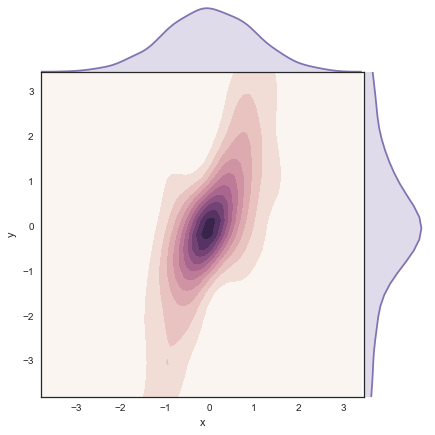

In [126]:
plot_samples(x, y, cmap=cmap, saveas='true_distrib.png')

In [118]:
fig.savefig('weird_gaussian.png', dpi=300)

In [854]:
tf.reset_default_graph()
standard_normal = Normal(0., 1.)

x_mu = tf.get_variable(shape=[], dtype=tf.float32, name='x_mu')
x_std = tf.get_variable(shape=[], dtype=tf.float32, name='x_std')
x_distrib = Normal(x_mu, x_std**2)

n = tf.Variable(N, dtype=tf.int32, trainable=False)
beta = tf.get_variable(shape=[], dtype=tf.float32, name='beta')
ff = tf.get_variable(shape=[], dtype=tf.float32, name='f')

xx = x_distrib.sample(n)
zz = standard_normal.sample(n)

fxx = ff * xx
vv = fxx ** 2 + beta ** 2
ss = tf.sqrt(vv)

y_distrib = Normal(fxx, ss)
yy = y_distrib.sample()

In [855]:
rec_loss = - tf.reduce_mean(y_distrib.log_prob(y.astype(np.float32)))
y_kl = tf.reduce_mean(_kl(y_distrib, standard_normal))
x_kl = tf.reduce_mean(_kl(x_distrib, standard_normal))
kl = y_kl + x_kl
loss = rec_loss + kl

In [934]:
opt = tf.train.RMSPropOptimizer(1e-4, momentum=.9, centered=True)
train_step = opt.minimize(rec_loss)

In [935]:
# sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [862]:
a, b, vf, vbeta = sess.run([xx, yy, ff, beta])
print vbeta ** 2
print vf

0.039395166171
0.87096


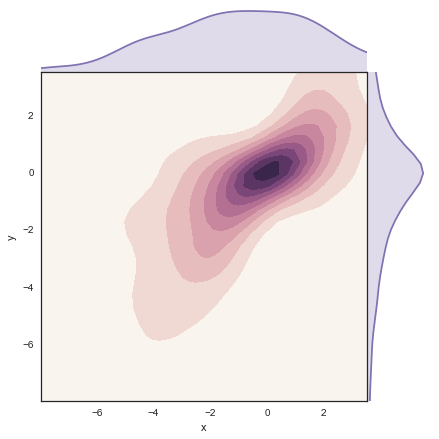

In [866]:
plot_samples(a, b, scale=.3, cmap=cmap, saveas='init_distrib')

In [908]:
sess.run([loss, rec_loss, y_kl, x_kl])

[20.683359, 19.355722, 0.41304693, 0.91458941]

In [989]:
print sess.run([loss, rec_loss, y_kl, x_kl])
for i in xrange(1000):
    sess.run([train_step, loss])
print sess.run([loss, rec_loss, y_kl, x_kl])

[7.0473127, 2.4370253, 2.3125784, 2.297709]
[6.8227415, 2.437053, 2.3126328, 2.0730562]


In [948]:
a, b, vf, vbeta = sess.run([xx, yy, ff, beta])
print vbeta ** 2
print vf

7.66172174619
0.0134461


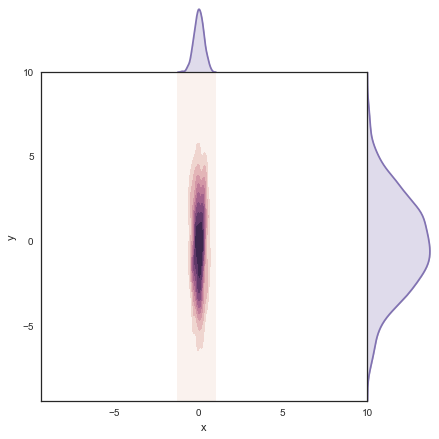

In [949]:
plot_samples(a, b, scale=1, cmap=cmap)